In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from kendapy.ekf import Ekf
datapath='/home/l/Leonhard.Scheck/kenda_experiments/cosmo_letkf/feedback/0605.103/20160605120000/'

Open a feedback file and check how many observations and which observation types and variables are available:

In [2]:
ekf=Ekf(datapath+'ekfSYNOP_20160605120000.nc')
print('number of observations: ', ekf.n_obs() )
print('variable names: ', ekf.varnames )
print('observation types: ', ekf.obstypes )

number of observations:  23444
variable names:  ['NHcbh', 'NL', 'T2M', 'TD2M', 'U10M', 'V10M', 'SDEPTH', 'UNKNOWN237', 'PS', 'DD', 'FF', 'RR', 'GUST', 'UNKNOWN238', 'UNKNOWN239', 'VV', 'NH', 'RH2M', 'N', 'NM', 'PTEND']
observation types:  ['SYNOP']


In most cases we will be interested only in a subset, e.g. the active surface pressure observations. The filter keyword can be used to get rid of all other observations:

In [3]:
ekf=Ekf(datapath+'ekfSYNOP_20160605120000.nc', filter='state=active varname=PS')
print('number of observations: ', ekf.n_obs() )
print('variable names: ', ekf.varnames )

number of observations:  637
variable names:  ['PS']


Plot SYNOP station locations and measured pressures as a function of time. All observation parameters can be accessed with "ekf.obs(param=...)". When "param" is not specified, the observed values are returned.

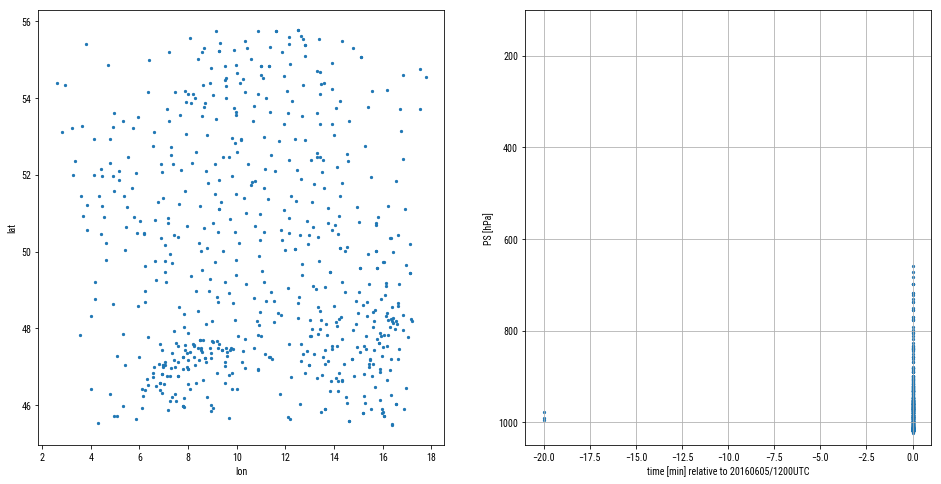

In [4]:
fig, ax = plt.subplots( 1, 2, figsize=(16,8))
ax[0].scatter( ekf.obs(param='lon'), ekf.obs(param='lat'), s=5 )
ax[0].set_xlabel('lon')
ax[0].set_ylabel('lat')
ax[1].scatter( ekf.obs(param='time'), ekf.obs()/100, s=5 )
ax[1].set_xlabel('time [min] relative to {}/{}UTC'.format(ekf.attr['verification_ref_date'],ekf.attr['verification_ref_time']))
ax[1].set_ylabel('PS [hPa]')
ax[1].set_ylim((1050,100))
ax[1].grid()


The model equivalents can be accessed using the ekf.veri() method or more intuitive aliases for it like fgens() for first guess ensemble, fgmean() for first guess ensemble mean etc.

Text(0,0.5,'model')

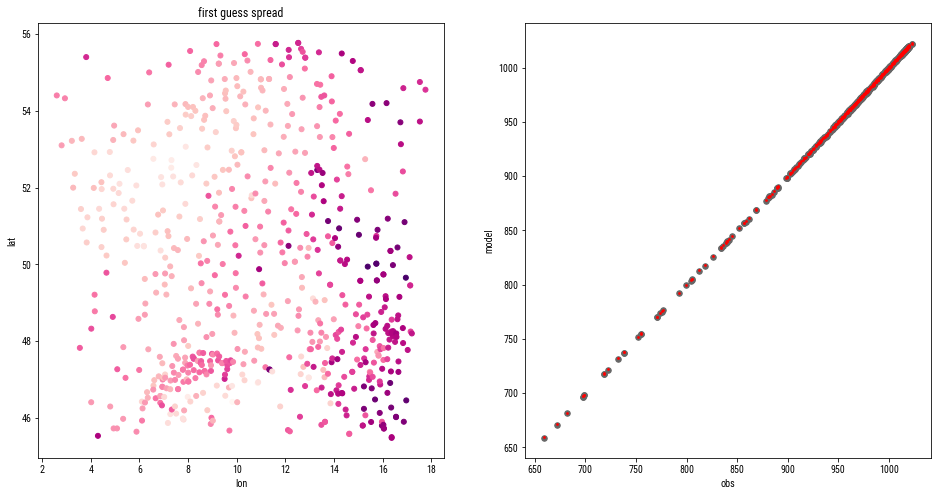

In [5]:
fig, ax = plt.subplots( 1, 2, figsize=(16,8))
#ax[0].scatter( ekf.obs(param='time'), ekf.fgspread() )
smin, smax = ekf.fgspread().min(), ekf.fgspread().max()
ax[0].scatter( ekf.obs(param='lon'), ekf.obs(param='lat'), s=25, c=['{:.2f}'.format((np.clip(v,smin,smax)-smin)/(smax-smin)) for v in ekf.fgspread()], cmap='RdPu' )
ax[0].set_xlabel('lon')
ax[0].set_ylabel('lat')
ax[0].set_title('first guess spread')

ax[1].scatter( ekf.obs()/100, ekf.fgmean()/100,  s=30, c='#666666')
ax[1].scatter( ekf.obs()/100, ekf.anamean()/100, s=3, c='r')
ax[1].set_xlabel('obs')
ax[1].set_ylabel('model')


Also feedobs files generated by COSMO can be read... In general they contain observations of several different observation types, but verification data (model equvalents) for only one member.

In [6]:
fof=Ekf(datapath+'fof_20160605120000_ens001.nc', filter='state=active')
print('number of observations: ', fof.n_obs() )
print('variable names: ', fof.varnames )
print('observation types: ', fof.obstypes )

number of observations:  8341
variable names:  ['T', 'U', 'V', 'T2M', 'TD2M', 'U10M', 'V10M', 'PS', 'DD', 'FF', 'RH2M', 'RH']
observation types:  ['SYNOP', 'AIREP', 'PILOT']


Plot V as a function of time and pressure for a specific wind profiler ans all aircrafts

number of active PILOT observations:  974
variable names:  ['U', 'V']
observation types:  ['PILOT']
number of observations from station 10394 : 85
min/max observed value -9.762863 1.9836102

number of AIREP V observations:  950
min/max observed value -35.224525 8.799518



Text(0,0.5,'pressure [hPa]')

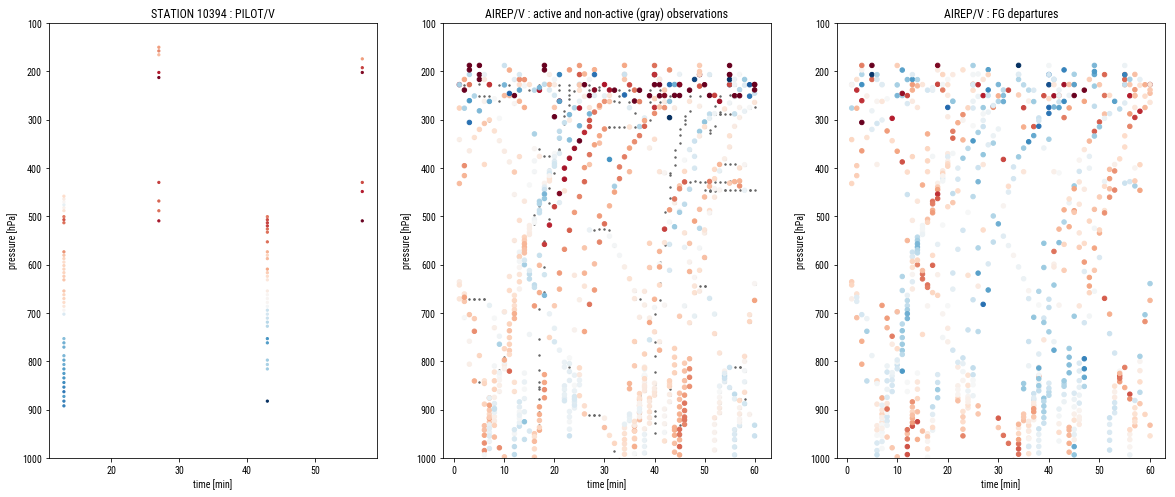

In [7]:
fof=Ekf(datapath+'fof_20160605120000_ens001.nc', filter='state=active obstype=PILOT')
print('number of active PILOT observations: ', fof.n_obs() )
print('variable names: ', fof.varnames )
print('observation types: ', fof.obstypes )

statid = fof.statids()[0]
# add filters for variable name and station (state and obstype filters stay active)
fof.add_filter(filter='varname=V station='+statid)
print('number of observations from station {} : {}'.format(statid,fof.n_obs()) )
print('min/max observed value', fof.obs().min(), fof.obs().max())
fig, ax = plt.subplots( 1, 3, figsize=(20,8))
ax[0].scatter( fof.obs(param='time'), fof.obs(param='plevel')/100, s=5, c=['{:.2f}'.format(np.clip(v,-10,10)/20+0.5) for v in fof.obs()], cmap='RdBu' )
ax[0].set_ylim((1000,100))
ax[0].set_title('STATION {} : PILOT/V'.format(statid))
ax[0].set_xlabel('time [min]')
ax[0].set_ylabel('pressure [hPa]')

print()
# use a different filter (filters specified so far are removed)
fof.replace_filter(filter='obstype=AIREP varname=V')
print('number of AIREP V observations: ', fof.n_obs() )
print('min/max observed value', fof.obs().min(), fof.obs().max())
# plot pressure vs. time  of all AREP V observations as gray dots
ax[1].scatter( fof.obs(param='time'), fof.obs(param='plevel')/100, s=2, c='#666666' )

# temporarily active, additional filter keywords can be also be specified for obs() and other methods of Ekf
# example: plot only active AIREP V observation, colored according to the observed value
ax[1].scatter( fof.obs(param='time',filter='state=active'),
               fof.obs(param='plevel',filter='state=active')/100, s=20,
               c=['{:.2f}'.format(np.clip(v,-10,10)/20+0.5) for v in fof.obs(filter='state=active')], cmap='RdBu' )
ax[1].set_ylim((1000,100))
ax[1].set_title('AIREP/V : active and non-active (gray) observations')
ax[1].set_xlabel('time [min]')
ax[1].set_ylabel('pressure [hPa]')

print()
# plot first guess departures
fof.replace_filter(filter='obstype=AIREP varname=V state=active')
fgdep = fof.fg()-fof.obs()
ax[2].scatter( fof.obs(param='time'),
               fof.obs(param='plevel')/100, s=20,
               c=['{:.2f}'.format(np.clip(v,-10,10)/20+0.5) for v in fgdep], cmap='RdBu' )
ax[2].set_ylim((1000,100))
ax[2].set_title('AIREP/V : FG departures')
ax[2].set_xlabel('time [min]')
ax[2].set_ylabel('pressure [hPa]')


Observations are organised in reports. In some cases it can be interesting to access these reports instead of the individual observations. The report() method returns a list of report numbers and the report filter can be used to select individual reports.

In [8]:
temp=Ekf(datapath+'fof_20160605110000_ens001.nc', filter='state=active obstype=TEMP', verbose=False)
#temp=Ekf(datapath+'ekfTEMP_20160605120000.nc',verbose=True)
print('found {} observations in {} reports...'.format(temp.n_obs(),temp.n_rep()))
reports = temp.reports()
print('report numbers : ', reports)
for r in reports :
    print('- report {} contains {} observations'.format( r, len(temp.obs(filter='report={}'.format(r))) ))
print('available variables: ', temp.varnames)

found 945 observations in 13 reports...
report numbers :  [833, 1057, 835, 580, 1059, 582, 138, 336, 338, 438, 440, 347, 349]
- report 833 contains 2 observations
- report 1057 contains 2 observations
- report 835 contains 100 observations
- report 580 contains 2 observations
- report 1059 contains 147 observations
- report 582 contains 151 observations
- report 138 contains 115 observations
- report 336 contains 2 observations
- report 338 contains 139 observations
- report 438 contains 4 observations
- report 440 contains 144 observations
- report 347 contains 2 observations
- report 349 contains 135 observations
available variables:  ['T', 'U', 'V', 'T2M', 'U10M', 'V10M', 'RH2M', 'HEIGHT', 'RH']


Plot T(P) for one specific radio sonde ascent (in this case report #835) and the corresponding model equivalent.

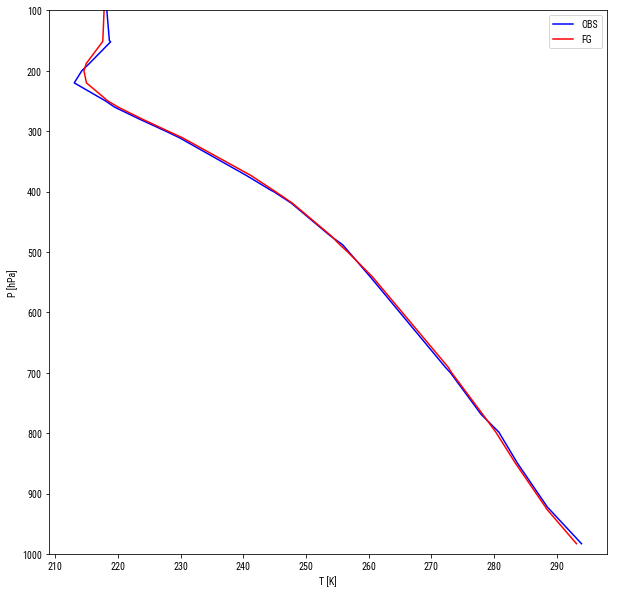

In [9]:
temp.add_filter(filter='report=835 varname=T')
fig, ax = plt.subplots( figsize=(10,10))
ax.plot( temp.obs(), temp.obs(param='level')/100, 'b', label='OBS')
ax.plot( temp.fg(), temp.obs(param='level')/100, 'r', label='FG')
ax.set_ylim((1000,100))
ax.set_xlabel('T [K]')
ax.set_ylabel('P [hPa]')
ax.legend(loc='upper right')